In [106]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchio as tio
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F

from segmenter import Segmenter

In [21]:
# TODO CMD arguments
version_folder = "version_17"
device = "cuda"
root = "C:/Users/denni/Documents/fallstudie-ss2024/logs/lightning_logs/"
data_root = "D:/Deep Learning/Task01_BrainTumour/"
# input patch size
# train_test_split
# patch overlap

In [39]:
checkpoint = torch.load(root + version_folder + "/checkpoints/epoch=48-step=25186.ckpt")

In [ ]:
# TODO Remove this later!!
checkpoint[]

In [71]:
print(checkpoint["hyper_parameters"])

{'in_channels': 4, 'out_channels': 4, 'odd_kernel_size': 3, 'activation_fn': ReLU(), 'learning_rate': 0.0001}


In [72]:
def get_models_and_metadata(version_path: str):
    path = Path(version_path + "/checkpoints")
    
    checkpoint_paths = list(path.glob("*"))
    model_list = []
    metadata_list = []
    
    for path in checkpoint_paths:
        model = Segmenter.load_from_checkpoint(path)
        model_list.append(model)
        
        metadata = torch.load(path)
        metadata_list.append(metadata)
        
    return model_list, metadata_list

In [73]:
models, metadatas = get_models_and_metadata(root + version_folder)

C:\Users\denni\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.


In [26]:
def change_img_to_label_path(path):
    """ Returns all directories in a path. """
    parts = list(path.parts)
    # Replace path
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [27]:
path = Path(data_root + "/imagesTr")
subject_paths = list(path.glob("BRATS_*"))
subjects = []

for subject_path in subject_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"MRI": tio.ScalarImage(subject_path), 
                        "Label": tio.LabelMap(label_path)})
    subjects.append(subject)

In [28]:
# Validation data processing
process = tio.Compose([
    tio.CropOrPad((240, 240, 155)),
    tio.RescaleIntensity((-1, 1))
])

In [29]:
num_subjects = len(subjects)
train_split = 0.85
split_index = int(num_subjects * train_split)
val_dataset = tio.SubjectsDataset(subjects[num_train_elements:], transform=process)

In [168]:
def masked(a):
    return np.ma.masked_where(a == 0, a)

In [194]:
def show_mri_and_pred(subject_num, slice_num, pred, train=False, save=False):
    plt.figure()
    ground_truth = val_dataset if not train else train_dataset
    plt.imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    plt.imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5, cmap="autumn")
    title_start = "Training" if train else "Eval"
    plt.title(f"{title_start} subject {subject_num}, slice {slice_num}")
    plt.suptitle("Prediction", y=0.05, fontsize=10)
    if save:
        plt.savefig(f"{subject_num}-{slice_num}.png")

KeyboardInterrupt: 

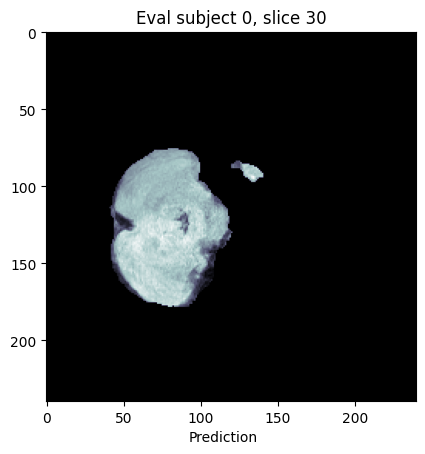

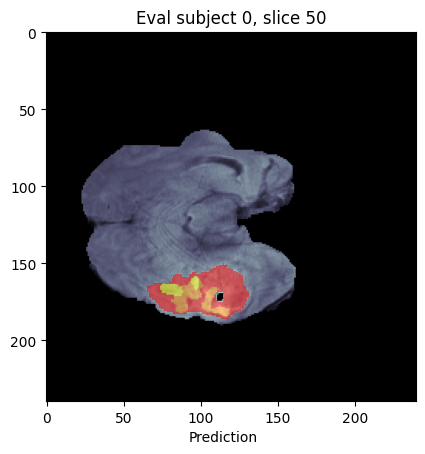

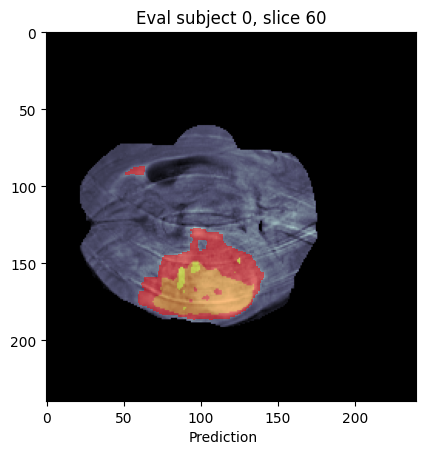

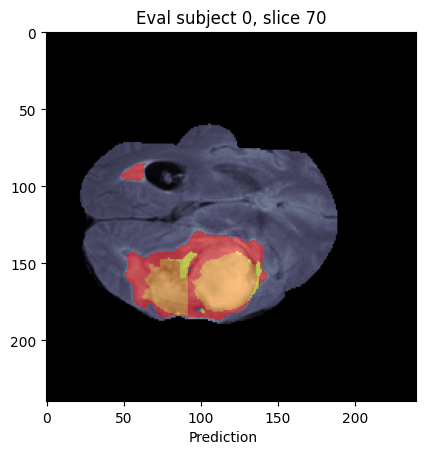

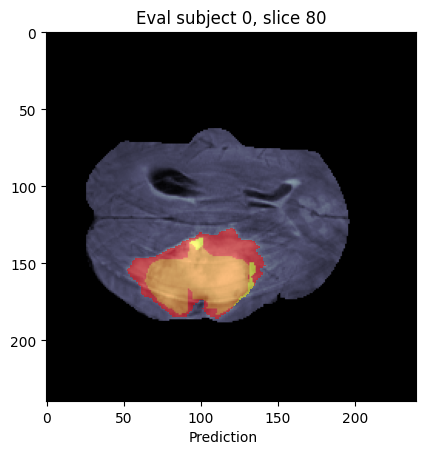

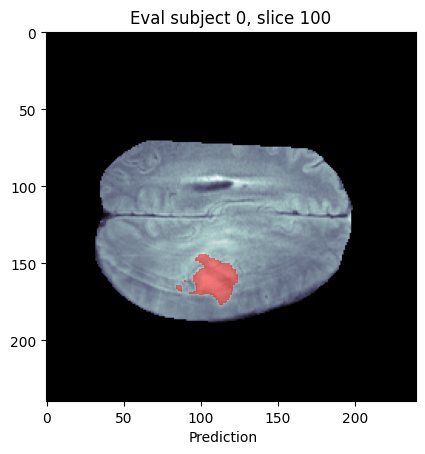

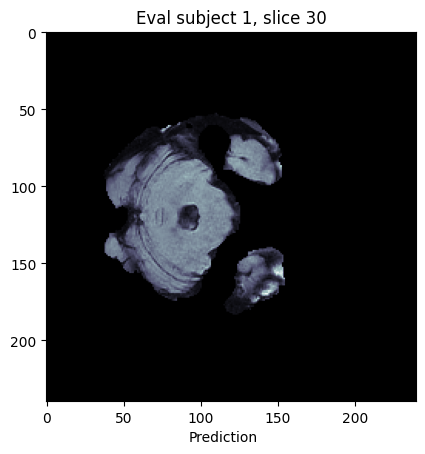

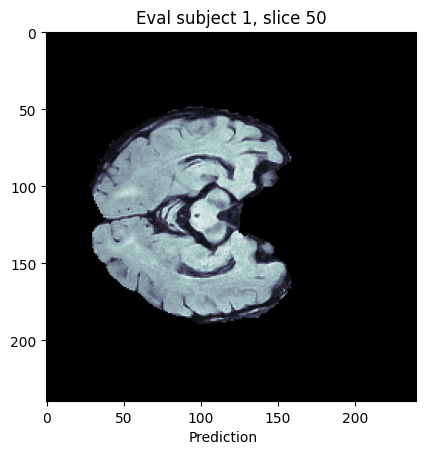

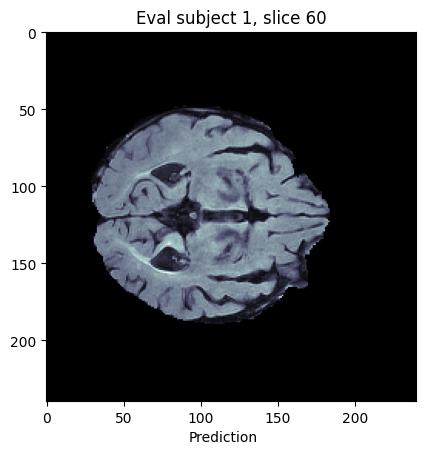

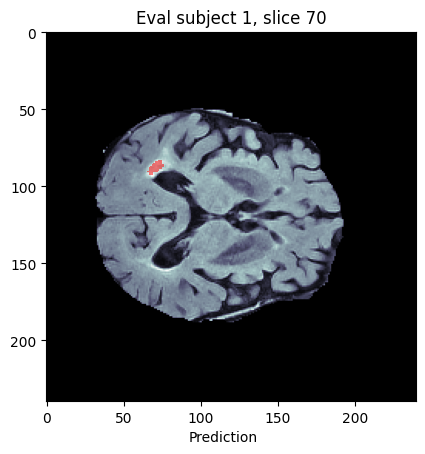

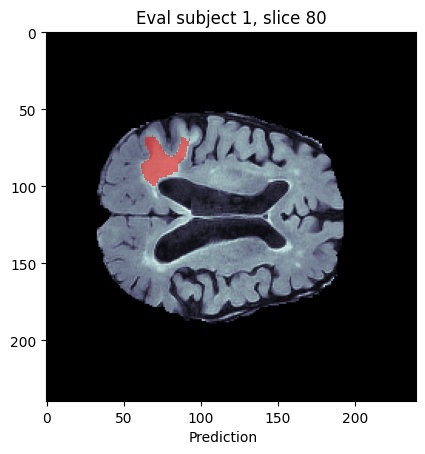

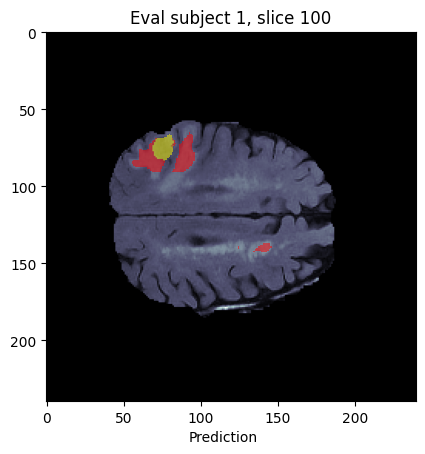

In [195]:
# Iterate all saved checkpoints, i.e., the model with the metadata and find out which one performs best on the
# validation data. That best model will be used to perform more in-depth analysis on the loss and to visualize
# the segmented tumors of the model.
loss_per_model = []
for index, (model, metadata) in enumerate(zip(models, metadatas)):
    # Switch the model to eval mode
    # print(f"Evaluating model {index} from epoch {metadata['epoch']}")
    model.eval()
    model.to(device)
    total_loss = 0.0
    
    # Load the patches from the current subject
    # for subject_num in tqdm(range(len((val_dataset)))):
    for subject_num in range(len(val_dataset)):
        grid_sampler = tio.inference.GridSampler(val_dataset[subject_num], 96, (8, 8, 8))
        aggregator = tio.inference.GridAggregator(grid_sampler)
        patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)
        with torch.no_grad():
            for patches_batch in patch_loader:
                input_tensor = patches_batch["MRI"]["data"].to(device)
                locations = patches_batch[tio.LOCATION]
                pred = model(input_tensor)
                # We keep adding batches to the aggregator to later collect all the data.
                aggregator.add_batch(pred, locations)
        pred = aggregator.get_output_tensor().unsqueeze(dim=0)
        label = val_dataset[0]["Label"].data.long()
        loss = torch.nn.CrossEntropyLoss(reduction="mean")(pred, label)
        total_loss += loss
        # print(f"Loss: {loss}")
        
        # Visualization
        slices_to_show = [30, 50, 60, 70, 80, 100]
        for slice_num in slices_to_show:
            show_mri_and_pred(subject_num, slice_num, pred.squeeze(), save=True)
    
    average_loss = total_loss / len(val_dataset)
    loss_per_model.append(average_loss)
    # print(f"Average loss: {average_loss}")
    
    break

In [175]:
print(pred.shape)

torch.Size([1, 4, 240, 240, 155])


In [165]:
def show_mri_and_label(subject_num, slice_num, show_label=True, train=False):
    plt.figure()
    ground_truth = val_dataset if not train else train_dataset
    plt.imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    if show_label:
        plt.imshow(masked(ground_truth[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    plt.title(f"{title_start} subject {subject_num}, slice {slice_num}")
    plt.suptitle("Ground truth", y=0.05, fontsize=10)

In [166]:
def masked(a):
    return np.ma.masked_where(a == 0, a)

In [102]:
def show_mri_and_pred(subject_num, slice_num, pred, train=False):
    plt.figure()
    ground_truth = val_dataset if not train else train_dataset
    plt.imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    plt.imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    plt.title(f"{title_start} subject {subject_num}, slice {slice_num}")
    plt.suptitle("Prediction", y=0.05, fontsize=10)

In [ ]:
def show_all(subject_num, slice_num, pred, train=False):
    plt.figure(figsize=(20, 20))
    f, ax = plt.subplots(2)
    # Show ground truth image
    ground_truth = val_dataset if not train else train_dataset
    ax[0].set_position([0, 0, 0.8, 0.8])
    ax[0].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    ax[0].imshow(masked(ground_truth[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    ax[0].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(ground truth)")
    # ax[0].legend("Ground truth", y=0.05, fontsize=10)
    
    # Show prediction image
    ground_truth = val_dataset if not train else train_dataset
    ax[1].set_position([0.75, 0, 0.8, 0.8])
    ax[1].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    ax[1].imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    ax[1].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(pred)")

In [167]:
val_dataset[0]["MRI"].data.shape

torch.Size([4, 240, 240, 155])

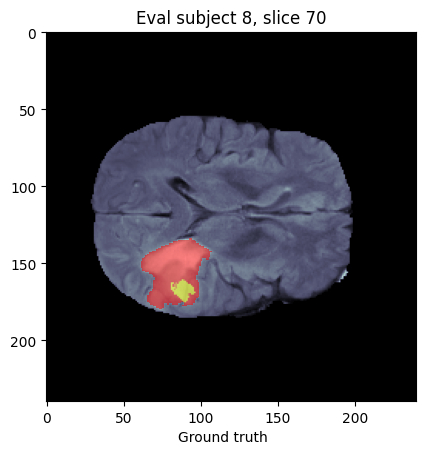

In [104]:
show_mri_and_label(IDX, 70, True)

In [136]:
def show_all(subject_num, slice_num, pred, train=False):
    plt.figure(figsize=(20, 20))
    f, ax = plt.subplots(2)
    # Show ground truth image
    ground_truth = val_dataset if not train else train_dataset
    ax[0].set_position([0, 0, 0.8, 0.8])
    ax[0].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    ax[0].imshow(masked(ground_truth[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    ax[0].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(ground truth)")
    # ax[0].legend("Ground truth", y=0.05, fontsize=10)
    
    # Show prediction image
    ground_truth = val_dataset if not train else train_dataset
    ax[1].set_position([0.75, 0, 0.8, 0.8])
    ax[1].imshow(ground_truth[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    max_likelihood_pred = pred.argmax(0)
    ax[1].imshow(masked(max_likelihood_pred[:, :, slice_num]), alpha=0.5,
                                  cmap="autumn")
    title_start = "Training" if train else "Eval"
    ax[1].set_title(f"{title_start} subject {subject_num}, slice {slice_num} \n(pred)")
    # ax[0].legend("Prediction", y=0.05, fontsize=10)

<Figure size 2000x2000 with 0 Axes>

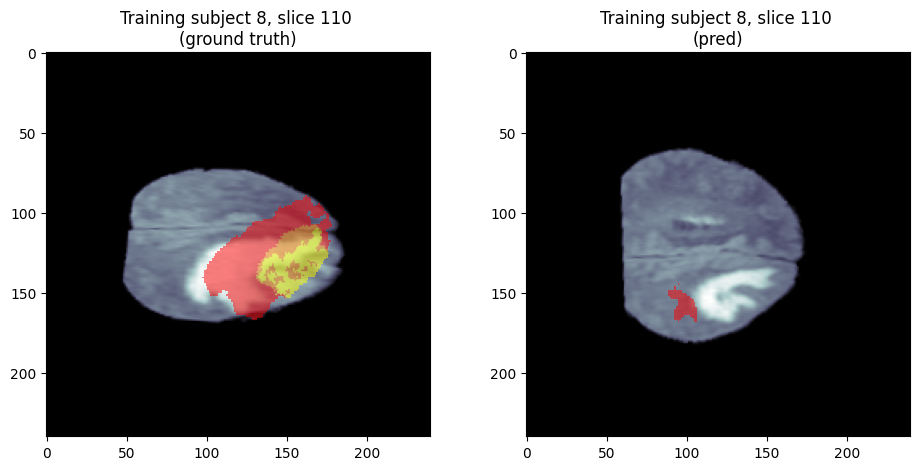

In [151]:
show_all(IDX, 110, pred, train=True)

In [26]:
subjects[12]["MRI"].data.unsqueeze(0).shape

torch.Size([1, 4, 240, 240, 155])

In [27]:
model(subjects[12]["MRI"].data.unsqueeze(0).cuda())

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 76 but got size 77 for tensor number 1 in the list.

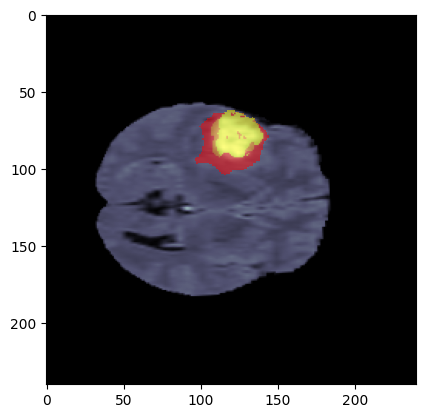

In [12]:
show_mri_and_label(3, 70, True)

In [ ]:
def show_mri_and_pred(subject_num, slice_num, model):
    plt.figure()
    plt.imshow(subjects[subject_num]["MRI"].data[0,:,:,slice_num], cmap="bone")
    if show_label:
        plt.imshow(masked(subjects[subject_num]["Label"].data[0,:,:,slice_num]), alpha=0.5,
                                  cmap="autumn")

In [ ]:
augmentation = {
    tio.RandomAffine(scales=(0.9, 1.1), degrees=(-25, 25)): 0,
    tio.RandomElasticDeformation(num_control_points=5): 1
}
pipeline = [
    tio.RandomElasticDeformation(num_control_points=10)
    # tio.RandomAffine(scales=(0.9, 1.1), degrees=(-25, 25))
]
pipeline2 = [
    tio.RandomAffine(scales=(1, 1), degrees=(0, 0), translation=(-20, 20, -20, 20, 0, 0))
]
new_data = tio.Compose(pipeline)(data).data
plt.figure()
plt.imshow(new_data[0, :, :, 70], cmap="bone")
plt.figure()
plt.imshow(data[0, :, :, 70], cmap="bone")